In [1]:
# Sel 1: Install dan Import Library
!pip install yfinance pandas numpy matplotlib scikit-learn seaborn

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Sel 2: Download Data Harga Emas

# Download data emas (GC=F adalah ticker untuk gold futures)
ticker = "GC=F"
data = yf.download(ticker, start="2005-01-01", end="2024-12-31")

# Cek data
print(f"Shape data: {data.shape}")
print("\n5 data teratas:")
print(data.head())

print("\nInfo dataset:")
print(data.info())

[*********************100%***********************]  1 of 1 completed

Shape data: (5025, 5)

5 data teratas:
Price            Close        High         Low        Open Volume
Ticker            GC=F        GC=F        GC=F        GC=F   GC=F
Date                                                             
2005-01-03  428.700012  431.000000  431.000000  431.000000      4
2005-01-04  428.500000  428.500000  428.500000  428.500000    108
2005-01-05  426.600006  425.700012  425.700012  425.700012      2
2005-01-06  421.000000  421.000000  421.000000  421.000000      1
2005-01-07  418.899994  423.700012  418.700012  423.700012      1

Info dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5025 entries, 2005-01-03 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, GC=F)   5025 non-null   float64
 1   (High, GC=F)    5025 non-null   float64
 2   (Low, GC=F)     5025 non-null   float64
 3   (Open, GC=F)    5025 non-null   float64
 4   (Volume, GC=F)  502

Exploratory Data Analysis


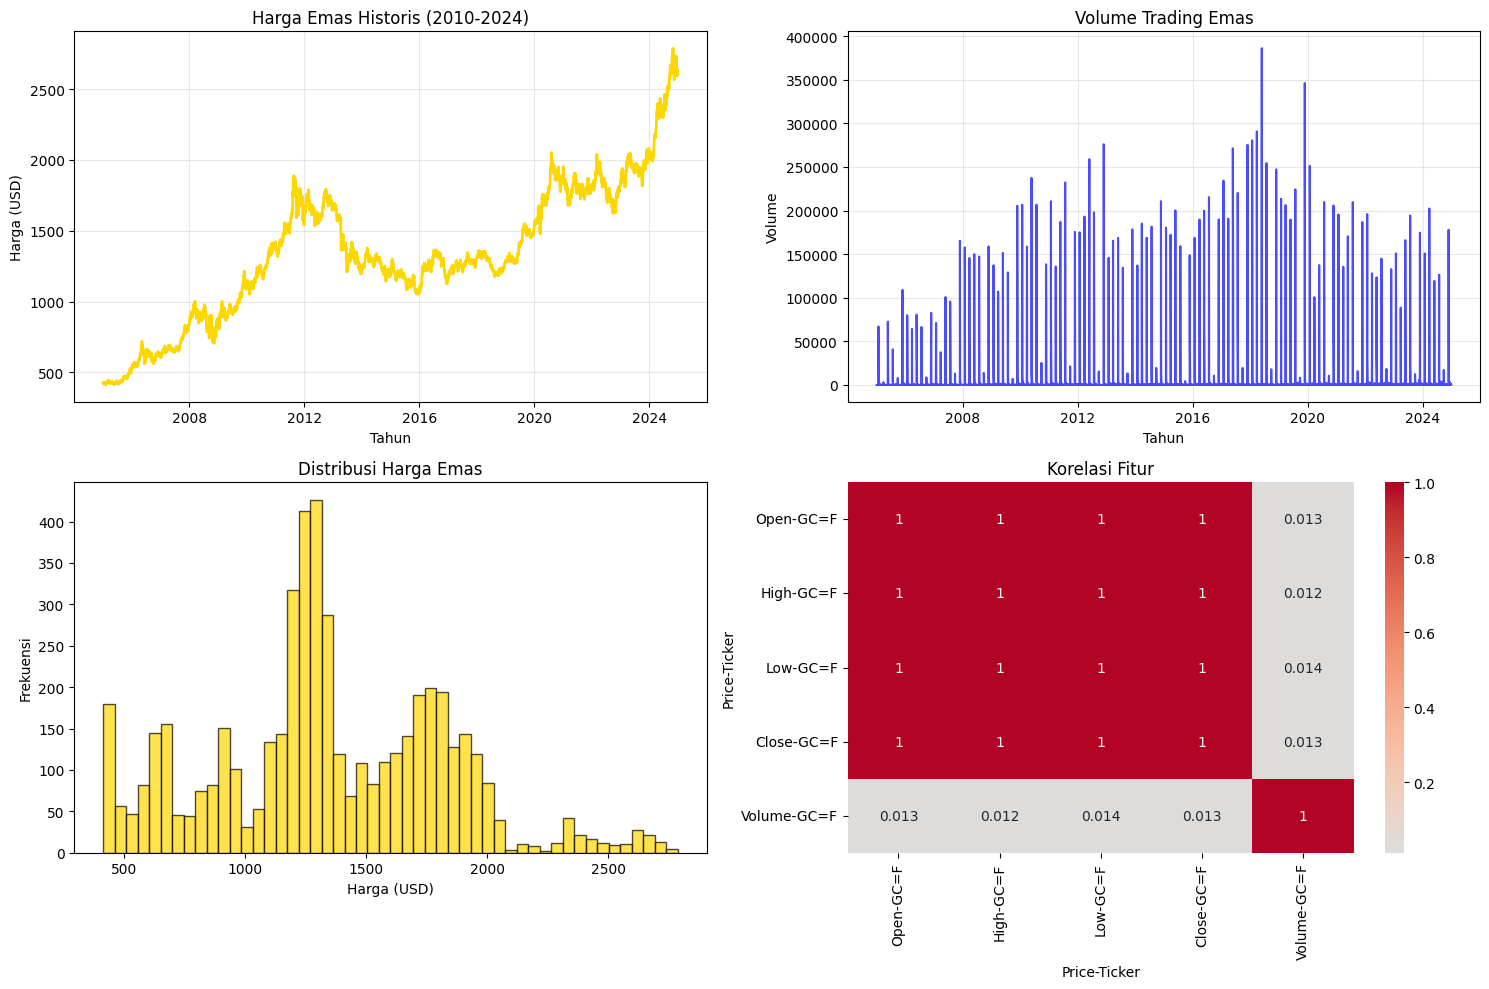


 Statistik Deskriptif:
Price         Close         High          Low         Open         Volume
Ticker         GC=F         GC=F         GC=F         GC=F           GC=F
count   5025.000000  5025.000000  5025.000000  5025.000000    5025.000000
mean    1338.596039  1345.458269  1331.568080  1338.673692    4877.056716
std      479.283722   481.649773   476.826712   479.231544   26483.194317
min      412.600006   413.600006   410.100006   412.000000       0.000000
25%     1083.699951  1090.800049  1076.800049  1084.300049      34.000000
50%     1293.500000  1297.800049  1288.000000  1293.300049     131.000000
75%     1711.000000  1720.000000  1701.900024  1710.000000     451.000000
max     2788.500000  2789.000000  2774.600098  2787.399902  386334.000000


In [3]:
# Sel 3: Exploratory Data Analysis (EDA)
print("Exploratory Data Analysis")

# Plot harga penutupan
plt.figure(figsize=(15, 10))

# Subplot 1: Harga Close
plt.subplot(2, 2, 1)
plt.plot(data.index, data['Close'], color='gold', linewidth=2)
plt.title('Harga Emas Historis (2010-2024)')
plt.xlabel('Tahun')
plt.ylabel('Harga (USD)')
plt.grid(True, alpha=0.3)

# Subplot 2: Volume trading
plt.subplot(2, 2, 2)
plt.plot(data.index, data['Volume'], color='blue', alpha=0.7)
plt.title('Volume Trading Emas')
plt.xlabel('Tahun')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)

# Subplot 3: Distribusi harga
plt.subplot(2, 2, 3)
plt.hist(data['Close'].dropna(), bins=50, color='gold', alpha=0.7, edgecolor='black')
plt.title('Distribusi Harga Emas')
plt.xlabel('Harga (USD)')
plt.ylabel('Frekuensi')

# Subplot 4: Korelasi
plt.subplot(2, 2, 4)
correlation = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Korelasi Fitur')

plt.tight_layout()
plt.show()

# Statistik deskriptif
print("\n Statistik Deskriptif:")
print(data.describe())

In [4]:
# Sel 4: Preprocessing Data

# Gunakan hanya kolom Close untuk forecasting
df = data[['Close']].copy()

# Handle missing values
print(f"Missing values sebelum: {df.isnull().sum().sum()}")
df = df.ffill()  # Forward fill
print(f"Missing values sesudah: {df.isnull().sum().sum()}")

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

print(f"Shape scaled data: {scaled_data.shape}")
print(f"Range data: {scaled_data.min():.3f} - {scaled_data.max():.3f}")

Missing values sebelum: 0
Missing values sesudah: 0
Shape scaled data: (5025, 1)
Range data: 0.000 - 1.000


In [5]:
# Sel 5: Membuat Sequences untuk Training
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Parameter
SEQUENCE_LENGTH = 60
TEST_SIZE = 0.2

# Create sequences
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

# Split data
split_index = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape untuk LSTM/GRU (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

X_train shape: (3972, 60, 1)
y_train shape: (3972,)
X_test shape: (993, 60, 1)
y_test shape: (993,)
Train size: 3972
Test size: 993


In [6]:
# Sel 6: Membangun Model LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)


model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Sel 7: Membangun Model GRU

model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 1)),
    Dropout(0.2),
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model_gru.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,851 (155.67 KB)

 Trainable params: 39,851 (155.67 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Sel 8: Training Model LSTM
history_lstm = model_lstm.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0018 - mae: 0.0346 - val_loss: 0.0108 - val_mae: 0.0675
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0275 - mae: 0.1068 - val_loss: 0.0099 - val_mae: 0.0709
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0300 - mae: 0.1113 - val_loss: 0.0233 - val_mae: 0.1426
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0596 - mae: 0.1458 - val_loss: 0.0202 - val_mae: 0.0915
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0613 - mae: 0.1618 - val_loss: 0.0597 - val_mae: 0.2142
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0524 - mae: 0.1751 - val_loss: 0.0602 - val_mae: 0.2219
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0340 - mae: 0.1327 - val_loss: 0.0207 - val_mae: 0.1221
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0237 - mae: 0.1043 - val_loss: 0.0020 - val_mae: 0.0402
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms

In [10]:
# Sel 9: Training Model GRU
history_gru = model_gru.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0021 - mae: 0.0363 - val_loss: 0.0072 - val_mae: 0.0548
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0191 - mae: 0.0926 - val_loss: 0.0063 - val_mae: 0.0674
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0234 - mae: 0.1012 - val_loss: 0.0131 - val_mae: 0.1048
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0501 - mae: 0.1391 - val_loss: 0.0212 - val_mae: 0.0949
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0479 - mae: 0.1436 - val_loss: 0.0261 - val_mae: 0.1320
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0246 - mae: 0.1020 - val_loss: 0.0019 - val_mae: 0.0401
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0066 - mae: 0.0590 - val_loss: 4.1868e-04 - val_mae: 0.0176
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0013 - mae: 0.0258 - val_loss: 5.4676e-04 - val_mae: 0.0207
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 

Visualisasi Training History


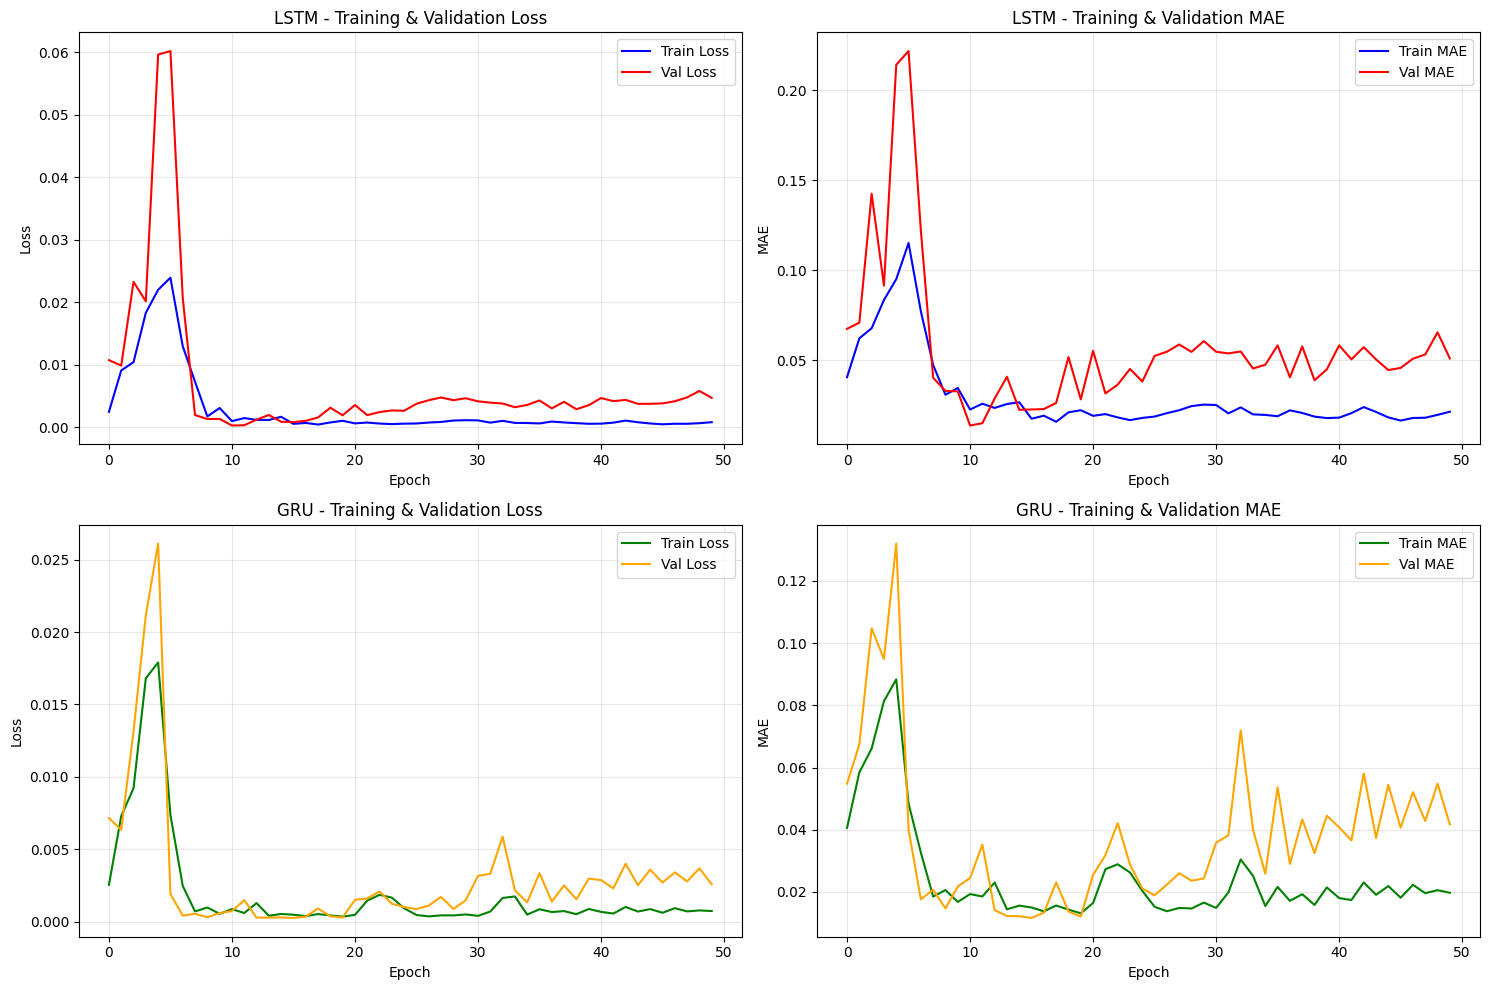

In [11]:
# Sel 10: Plot Training History
print("Visualisasi Training History")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# LSTM Loss
axes[0, 0].plot(history_lstm.history['loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history_lstm.history['val_loss'], label='Val Loss', color='red')
axes[0, 0].set_title('LSTM - Training & Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# LSTM MAE
axes[0, 1].plot(history_lstm.history['mae'], label='Train MAE', color='blue')
axes[0, 1].plot(history_lstm.history['val_mae'], label='Val MAE', color='red')
axes[0, 1].set_title('LSTM - Training & Validation MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# GRU Loss
axes[1, 0].plot(history_gru.history['loss'], label='Train Loss', color='green')
axes[1, 0].plot(history_gru.history['val_loss'], label='Val Loss', color='orange')
axes[1, 0].set_title('GRU - Training & Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# GRU MAE
axes[1, 1].plot(history_gru.history['mae'], label='Train MAE', color='green')
axes[1, 1].plot(history_gru.history['val_mae'], label='Val MAE', color='orange')
axes[1, 1].set_title('GRU - Training & Validation MAE')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Sel 11: Membuat Prediksi

# Prediksi dengan LSTM
lstm_train_pred = model_lstm.predict(X_train)
lstm_test_pred = model_lstm.predict(X_test)

# Prediksi dengan GRU
gru_train_pred = model_gru.predict(X_train)
gru_test_pred = model_gru.predict(X_test)

# Inverse transform ke nilai asli
lstm_train_pred = scaler.inverse_transform(lstm_train_pred)
lstm_test_pred = scaler.inverse_transform(lstm_test_pred)
gru_train_pred = scaler.inverse_transform(gru_train_pred)
gru_test_pred = scaler.inverse_transform(gru_test_pred)

# True values
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"LSTM train pred shape: {lstm_train_pred.shape}")
print(f"GRU test pred shape: {gru_test_pred.shape}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM train pred shape: (3972, 1)
GRU test pred shape: (993, 1)


Visualisasi Hasil Prediksi


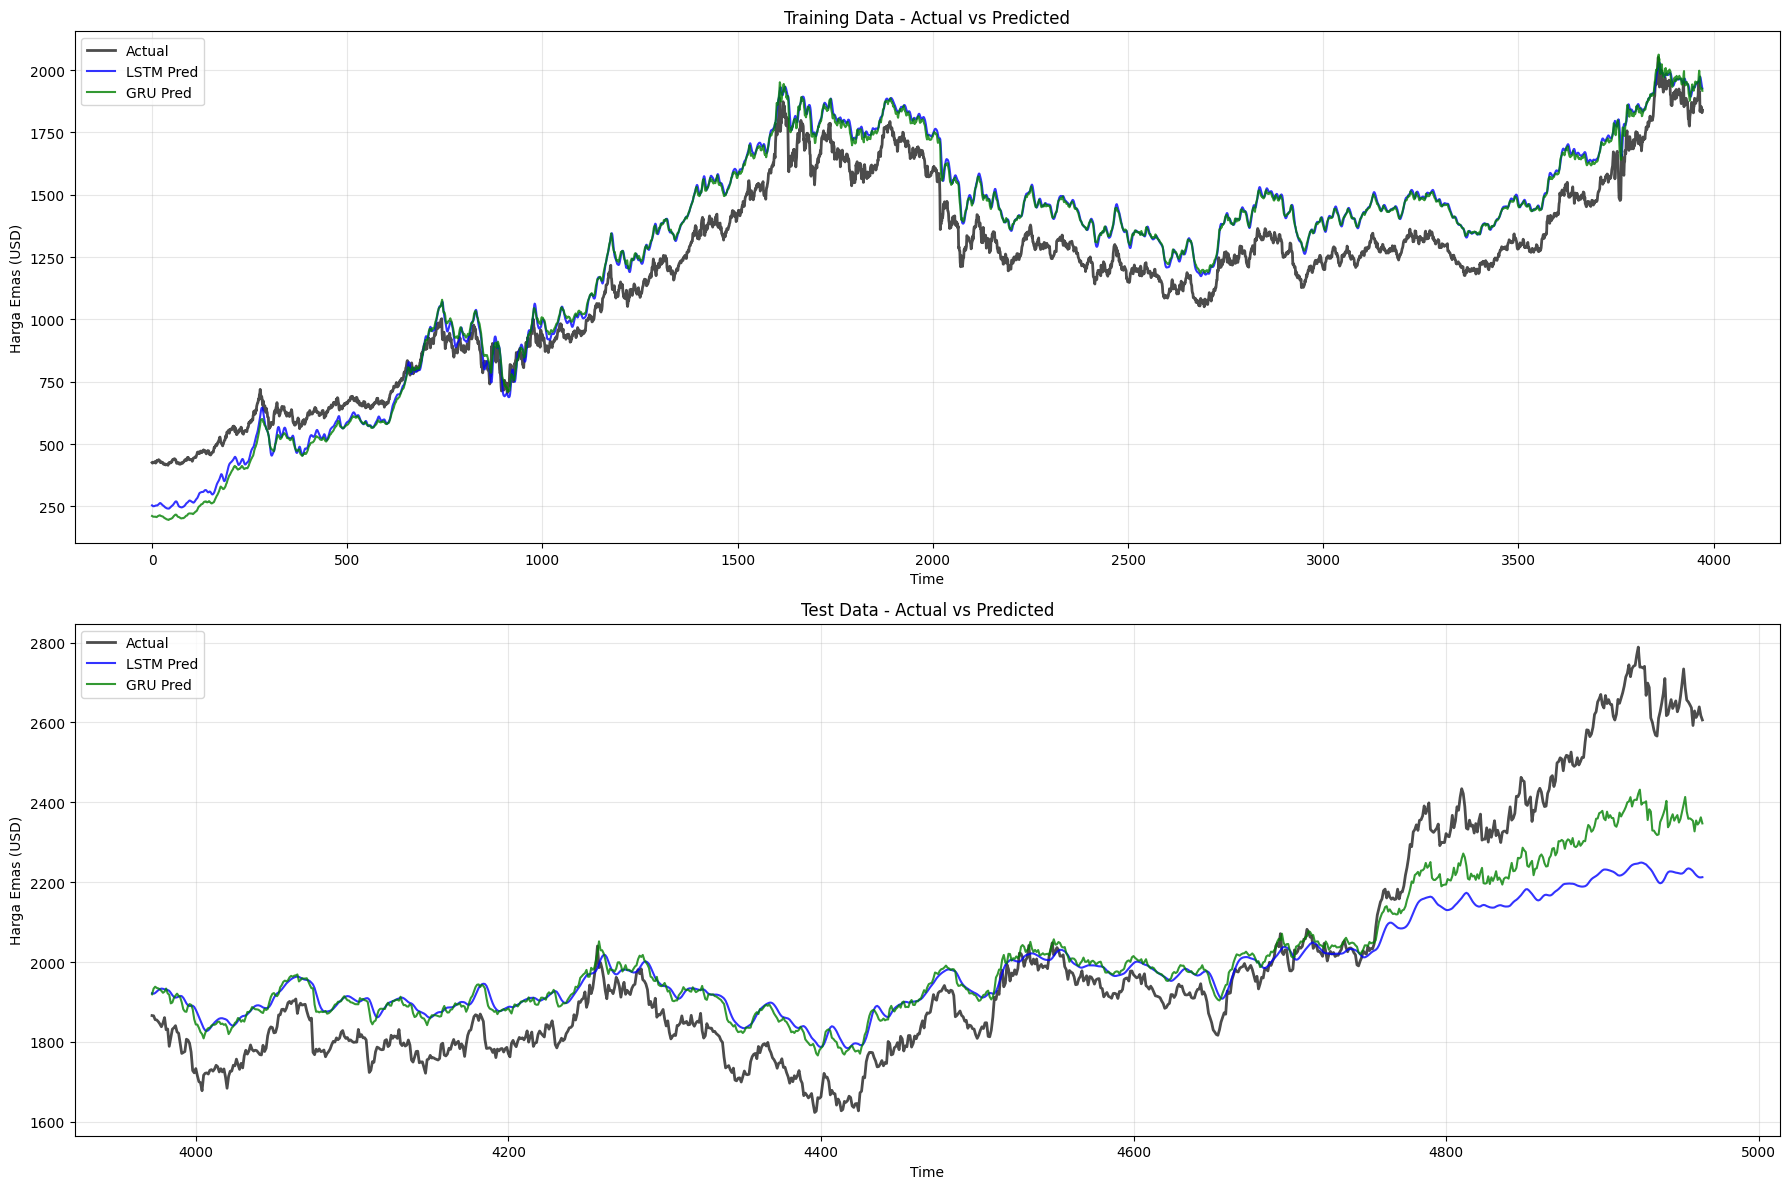

In [13]:
# Sel 12: Visualisasi Hasil Prediksi
print("Visualisasi Hasil Prediksi")

# Buat index untuk plotting
train_index = range(len(y_train_actual))
test_index = range(len(y_train_actual), len(y_train_actual) + len(y_test_actual))

plt.figure(figsize=(18, 12))

# Plot training data
plt.subplot(2, 1, 1)
plt.plot(train_index, y_train_actual, label='Actual', color='black', alpha=0.7, linewidth=2)
plt.plot(train_index, lstm_train_pred, label='LSTM Pred', color='blue', alpha=0.8)
plt.plot(train_index, gru_train_pred, label='GRU Pred', color='green', alpha=0.8)
plt.title('Training Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot test data
plt.subplot(2, 1, 2)
plt.plot(test_index, y_test_actual, label='Actual', color='black', alpha=0.7, linewidth=2)
plt.plot(test_index, lstm_test_pred, label='LSTM Pred', color='blue', alpha=0.8)
plt.plot(test_index, gru_test_pred, label='GRU Pred', color='green', alpha=0.8)
plt.title('Test Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Evaluasi Kuantitatif Model

 Hasil Evaluasi Model:
        Model         MSE       MAE      RMSE  R2_Score     MAPE
0  LSTM Train  19461.0102  130.3508  139.5027    0.8542  12.0417
1   LSTM Test  26763.2191  121.1369  163.5947    0.6450   5.7698
2   GRU Train  19564.2592  131.8456  139.8723    0.8534  12.6616
3    GRU Test  14558.9360   99.1501  120.6604    0.8069   4.8636


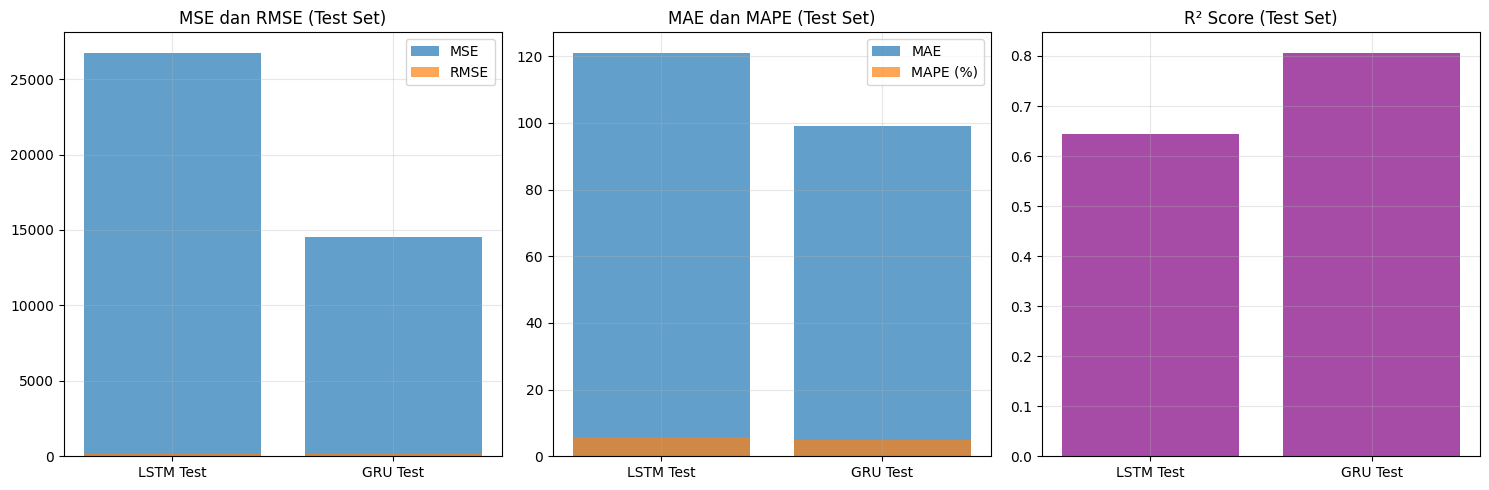

In [14]:
# Sel 13: Evaluasi Model - Metrik Kuantitatif
print("Evaluasi Kuantitatif Model")

def calculate_metrics(actual, predicted, model_name):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return {
        'Model': model_name,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2_Score': r2,
        'MAPE': mape
    }

# Hitung metrik untuk semua model
results = []

# LSTM
results.append(calculate_metrics(y_train_actual, lstm_train_pred, 'LSTM Train'))
results.append(calculate_metrics(y_test_actual, lstm_test_pred, 'LSTM Test'))

# GRU
results.append(calculate_metrics(y_train_actual, gru_train_pred, 'GRU Train'))
results.append(calculate_metrics(y_test_actual, gru_test_pred, 'GRU Test'))

# Buat DataFrame hasil
results_df = pd.DataFrame(results)
print("\n Hasil Evaluasi Model:")
print(results_df.round(4))

# Tampilkan perbandingan visual
plt.figure(figsize=(15, 5))

# Plot MSE dan RMSE
plt.subplot(1, 3, 1)
test_results = results_df[results_df['Model'].str.contains('Test')]
x = range(len(test_results))
plt.bar(x, test_results['MSE'], alpha=0.7, label='MSE')
plt.bar(x, test_results['RMSE'], alpha=0.7, label='RMSE')
plt.xticks(x, test_results['Model'])
plt.title('MSE dan RMSE (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot MAE dan MAPE
plt.subplot(1, 3, 2)
plt.bar(x, test_results['MAE'], alpha=0.7, label='MAE')
plt.bar(x, test_results['MAPE'], alpha=0.7, label='MAPE (%)')
plt.xticks(x, test_results['Model'])
plt.title('MAE dan MAPE (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R² Score
plt.subplot(1, 3, 3)
plt.bar(x, test_results['R2_Score'], alpha=0.7, color='purple')
plt.xticks(x, test_results['Model'])
plt.title('R² Score (Test Set)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Analisis Residual Error


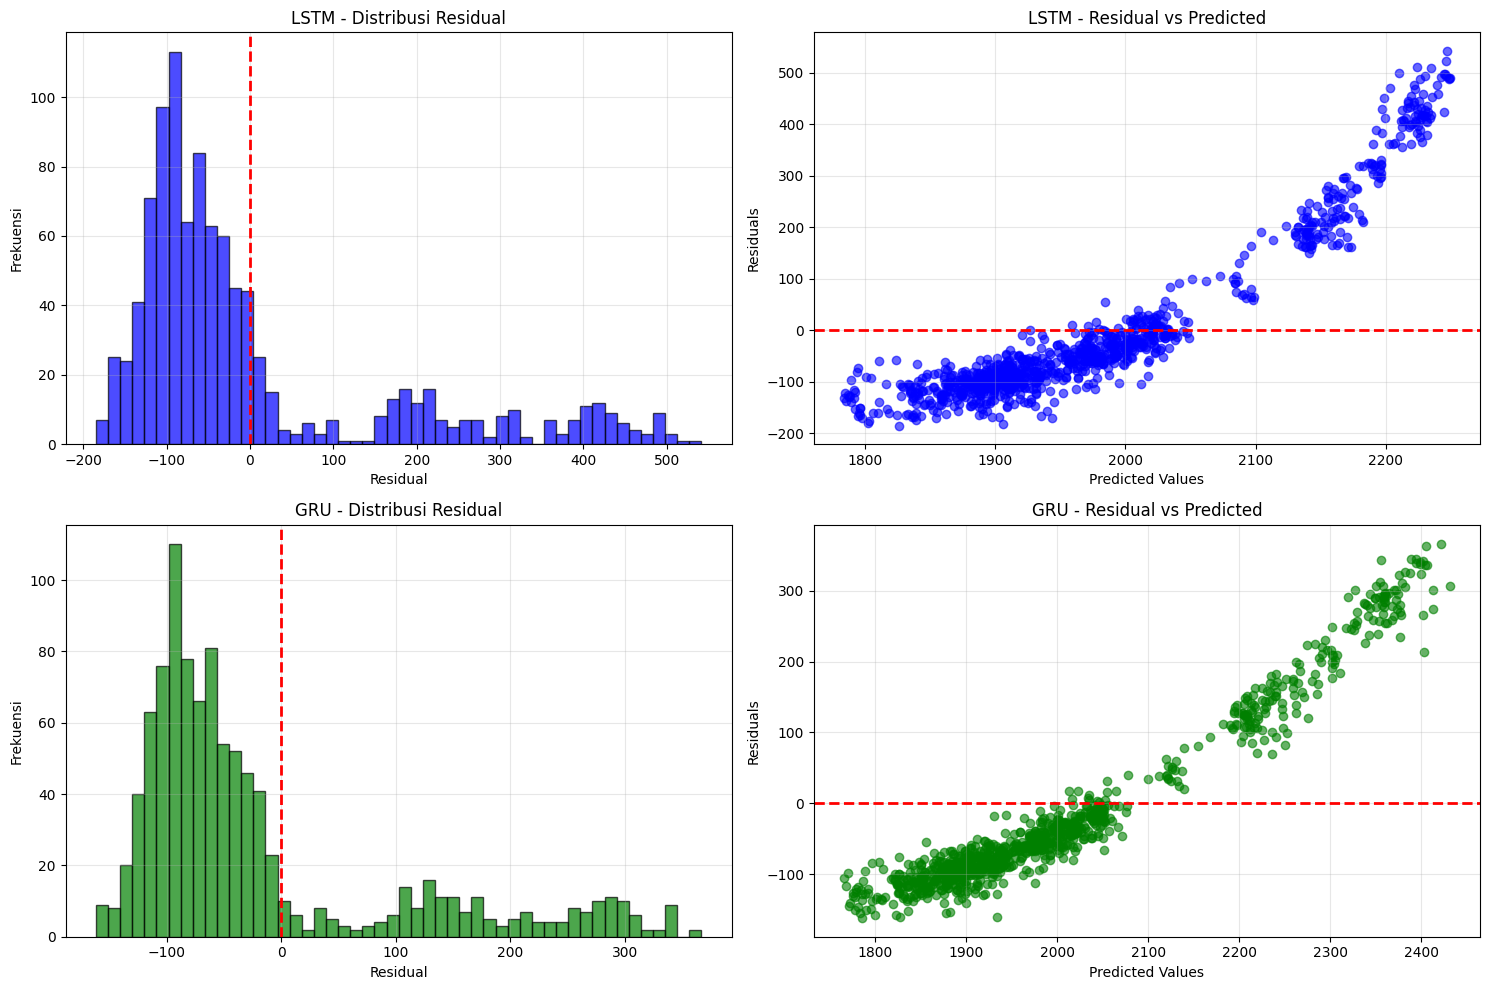


 Statistik Residual:
       LSTM_Residuals  GRU_Residuals
count        993.0000       993.0000
mean           1.8127       -19.8022
std          163.6671       119.0844
min         -184.8245      -161.8837
25%         -100.3018       -95.0469
50%          -58.8026       -62.7791
75%            6.7780       -13.4097
max          541.6201       366.7065


In [15]:
# Sel 14: Analisis Residual
print("Analisis Residual Error")

# Hitung residual
lstm_residuals = y_test_actual - lstm_test_pred
gru_residuals = y_test_actual - gru_test_pred

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram residual LSTM
axes[0, 0].hist(lstm_residuals, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('LSTM - Distribusi Residual')
axes[0, 0].set_xlabel('Residual')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot residual LSTM
axes[0, 1].scatter(lstm_test_pred, lstm_residuals, alpha=0.6, color='blue')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('LSTM - Residual vs Predicted')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].grid(True, alpha=0.3)

# Histogram residual GRU
axes[1, 0].hist(gru_residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('GRU - Distribusi Residual')
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frekuensi')
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot residual GRU
axes[1, 1].scatter(gru_test_pred, gru_residuals, alpha=0.6, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('GRU - Residual vs Predicted')
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistik residual
print("\n Statistik Residual:")
residual_stats = pd.DataFrame({
    'LSTM_Residuals': lstm_residuals.flatten(),
    'GRU_Residuals': gru_residuals.flatten()
}).describe()
print(residual_stats.round(4))

Forecasting 30 Hari ke Depan


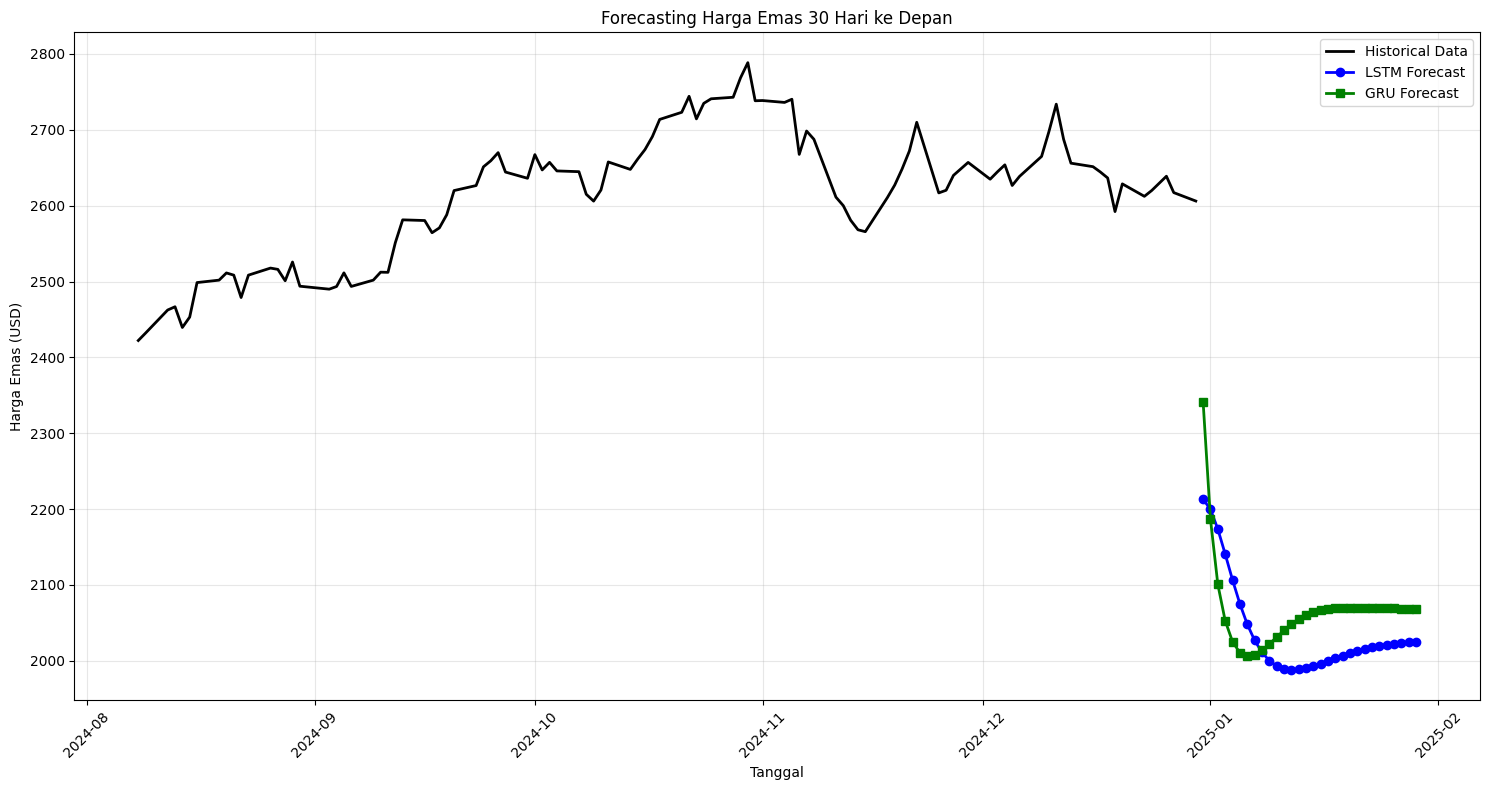

📅 Forecast 10 Hari Pertama:
     Tanggal  LSTM_Forecast  GRU_Forecast
0 2024-12-31    2212.860107   2340.699951
1 2025-01-01    2199.530029   2186.409912
2 2025-01-02    2173.590088   2100.689941
3 2025-01-03    2140.760010   2052.850098
4 2025-01-04    2106.629883   2025.199951
5 2025-01-05    2075.110107   2010.569946
6 2025-01-06    2048.340088   2005.599976
7 2025-01-07    2027.089966   2007.449951
8 2025-01-08    2011.250000   2013.569946
9 2025-01-09    2000.229980   2021.930054


In [16]:
# Sel 15: Forecasting Masa Depan
print("Forecasting 30 Hari ke Depan")

def forecast_future(model, last_sequence, days=30):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        # Predict next day
        next_pred = model.predict(current_sequence.reshape(1, SEQUENCE_LENGTH, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])

        # Update sequence
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]

    return np.array(future_predictions)

# Ambil sequence terakhir dari data test
last_sequence = scaled_data[-SEQUENCE_LENGTH:]

# Forecasting dengan kedua model
lstm_future = forecast_future(model_lstm, last_sequence, days=30)
gru_future = forecast_future(model_gru, last_sequence, days=30)

# Inverse transform
lstm_future = scaler.inverse_transform(lstm_future.reshape(-1, 1))
gru_future = scaler.inverse_transform(gru_future.reshape(-1, 1))

# Buat index untuk future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plot hasil forecasting
plt.figure(figsize=(15, 8))

# Plot data historis 100 hari terakhir
historical_days = 100
historical_dates = data.index[-historical_days:]
historical_prices = data['Close'].values[-historical_days:]

plt.plot(historical_dates, historical_prices, label='Historical Data', color='black', linewidth=2)
plt.plot(future_dates, lstm_future, label='LSTM Forecast', color='blue', linewidth=2, marker='o')
plt.plot(future_dates, gru_future, label='GRU Forecast', color='green', linewidth=2, marker='s')

plt.title('Forecasting Harga Emas 30 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("📅 Forecast 10 Hari Pertama:")
forecast_df = pd.DataFrame({
    'Tanggal': future_dates[:10],
    'LSTM_Forecast': lstm_future.flatten()[:10],
    'GRU_Forecast': gru_future.flatten()[:10]
})
print(forecast_df.round(2))